OBJECTIVES: Familiarize yourself with the SecureBank dataset provided. In an Jupyter ipython notebook titled (`securebank/analysis/data_analysis.ipynb`) complete the following tasks. You are permitted to use any python packages you find fit to accomplish the homework:

Task 1: Write a function called __merge() which takes the arguments customer_filename: str, transaction_filename: str, fraud_filename:str. This function should return a pandas DataFrame the merges data sources indexed by `trans_num`, and sorted by `trans_date_trans_time`.

Task 2: Analyze the data provided, and provide evidence using tables and graphs to corroborate (or disprove) the analysts' insights (FOUR total). Furthermore, provide TWO other insights you uncover through your initial analysis. Provide an argument for the results and use graphs, tables, etc., to support them.

SUBMISSION: You will need to check in your `securebank/analysis/data_analysis.ipynb` submission into your provisioned GitHub repository, and provide GitHub the URL link to this notebook via Canvas to get credit for this submission. Use proper markdown headings to delineate these tasks and subtasks.

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import json
import os

current_dir = os.getcwd()
base_path = os.path.join(os.path.dirname(current_dir), 'data_sources')
customer_filename = os.path.join(base_path, 'customer_release.csv')
transaction_filename = os.path.join(base_path, 'transactions_release.parquet')
fraud_filename = os.path.join(base_path, 'fraud_release.json')

def __merge(customer_filename: str, transaction_filename: str, fraud_filename: str) -> pd.DataFrame:
    # Read customer data from CSV
    customers = pd.read_csv(customer_filename)
    
    # Read transaction data from Parquet
    transactions = pq.read_table(transaction_filename).to_pandas()
    transactions.reset_index(inplace=True, drop=False)

    # Read fraud data from JSON
    with open(fraud_filename, 'r') as file:
        fraud_data = json.load(file)
    
    # Convert fraud data to DataFrame
    fraud = pd.DataFrame.from_dict(fraud_data, orient='index').T
    fraud = fraud.melt(var_name='trans_num', value_name='is_fraud')
    fraud['trans_num'] = fraud['trans_num'].astype(str)
    
    # Merge transactions with customers
    merged = transactions.merge(customers, left_on='cc_num', right_on='cc_num', how='left')
    merged.set_index('trans_num', inplace=True)
    
    # Merge with fraud data
    merged = merged.merge(fraud, on='trans_num', how='left')

    # Set index to trans_num and sort by trans_date_trans_time
    merged.set_index('trans_num', inplace=True)
    merged.sort_values('trans_date_trans_time', inplace=True)
    
    return merged

merged_data = __merge(customer_filename, transaction_filename, fraud_filename)
print(merged_data)

                                  index_x trans_date_trans_time  \
trans_num                                                         
0b242abb623afc578575680df30655b9        0   2019-01-01 00:00:18   
1f76529f8574734946361c461b024d99        1   2019-01-01 00:00:44   
a1a22d70485983eac12b5b88dad1cf95        2   2019-01-01 00:00:51   
6b849c168bdad6f867558c3793159a81        3   2019-01-01 00:01:16   
a41d7549acf90789359a9aa5346dcb46        4   2019-01-01 00:03:06   
...                                   ...                   ...   
9b1f753c79894c9f4b71f04581835ada  1852389   2020-12-31 23:59:07   
2090647dac2c89a1d86c514c427f5b91  1852390   2020-12-31 23:59:09   
6c5b7c8add471975aa0fec023b2e8408  1852391   2020-12-31 23:59:15   
14392d723bb7737606b2700ac791b7aa  1852392   2020-12-31 23:59:24   
1765bb45b3aa3224b4cdcb6e7a96cee3  1852393   2020-12-31 23:59:34   

                                            cc_num     unix_time  \
trans_num                                                   

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

### Analysts FOUR

1. The frequency of fraudulent transactions depends on the hour of the day the transaction occurs

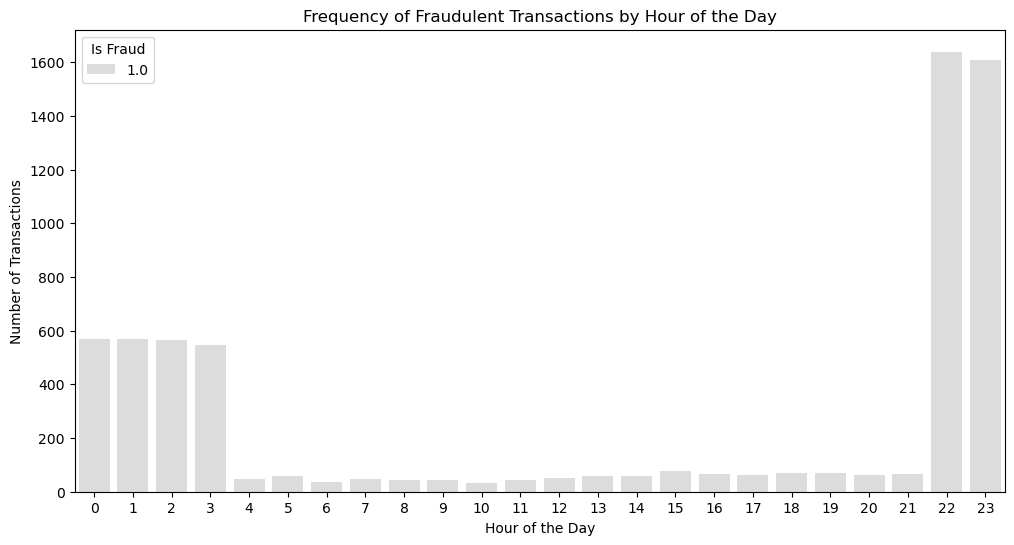

In [3]:
merged_data['hour'] = pd.to_datetime(merged_data['trans_date_trans_time']).dt.hour
fraud_data = merged_data[merged_data['is_fraud'] == 1]

plt.figure(figsize=(12, 6))
sns.countplot(x='hour', hue='is_fraud', data=fraud_data, palette='coolwarm', dodge=False)
plt.title('Frequency of Fraudulent Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.legend(title='Is Fraud')
plt.show()

The plot shows that fraudulent transactions tends to happen between 22:00 to 4:00 AM.


2. The frequency of fraudulent transactions depends on the day of week the transaction occurs

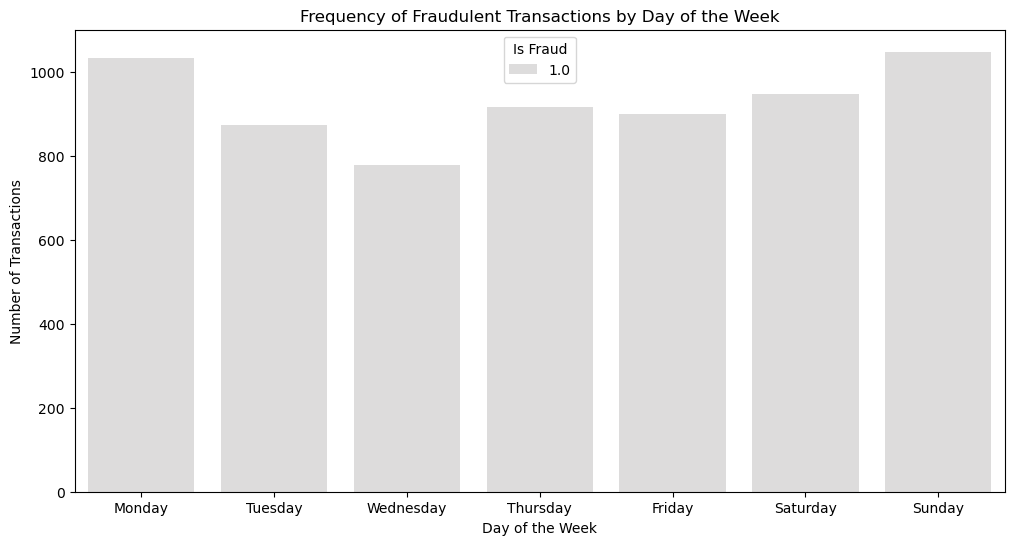

In [4]:
merged_data['day_of_week'] = pd.to_datetime(merged_data['trans_date_trans_time']).dt.day_name()
fraud_data = merged_data[merged_data['is_fraud'] == 1]

plt.figure(figsize=(12, 6))
sns.countplot(x='day_of_week', hue='is_fraud', data=fraud_data, palette='coolwarm', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], dodge=False)
plt.title('Frequency of Fraudulent Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.legend(title='Is Fraud')
plt.show()

The plot shows that there is no significant difference in the occurrence of fraudulent transactions across different days of the week.

3. The frequency of fraudulent transactions depends the month the transaction occurs

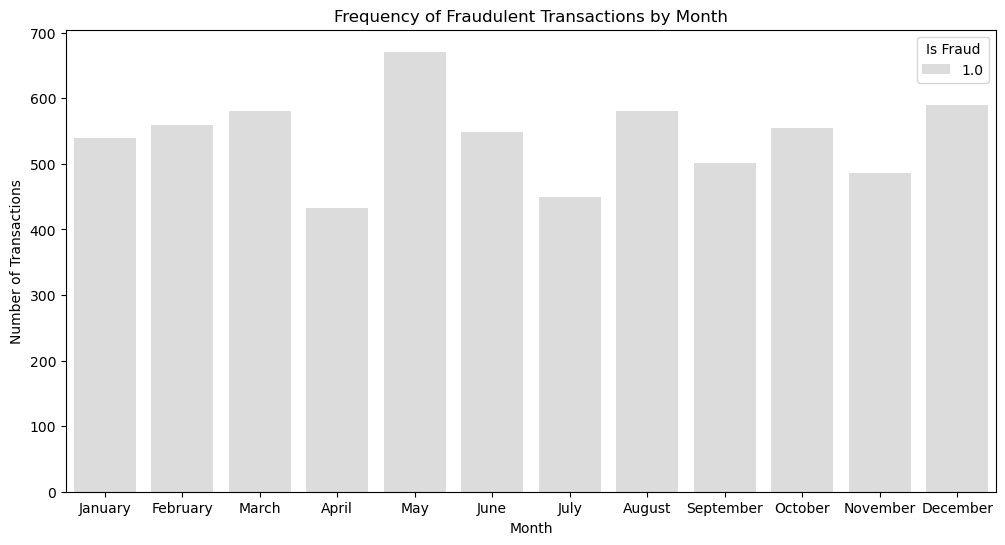

In [5]:
merged_data['month'] = pd.to_datetime(merged_data['trans_date_trans_time']).dt.month_name()
fraud_data = merged_data[merged_data['is_fraud'] == 1]

plt.figure(figsize=(12, 6))
sns.countplot(x='month', hue='is_fraud', data=fraud_data, palette='coolwarm', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], dodge=False)
plt.title('Frequency of Fraudulent Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.legend(title='Is Fraud')
plt.show()

The plot shows that there is no significant difference in the occurrence of fraudulent transactions across months.

4. Fraudulent transactions are likely to occur in quick succession

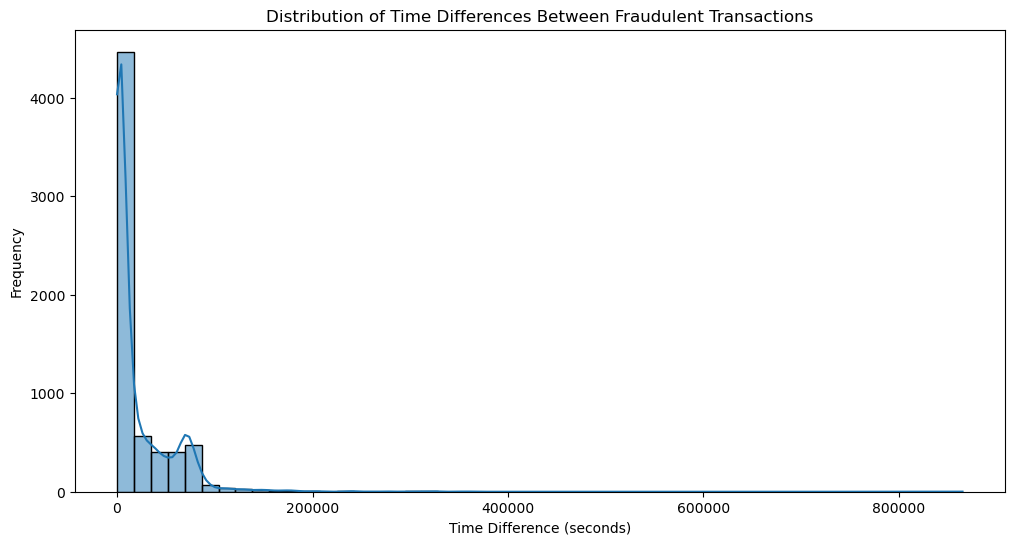

In [6]:
merged_data['trans_date_trans_time'] = pd.to_datetime(merged_data['trans_date_trans_time'])
merged_data = merged_data.sort_values(by=['cc_num', 'trans_date_trans_time'])
merged_data['time_diff'] = merged_data.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()

plt.figure(figsize=(12, 6))
fraud_data = merged_data[merged_data['is_fraud'] == 1]
sns.histplot(fraud_data['time_diff'].dropna(), bins=50, kde=True)
plt.title('Distribution of Time Differences Between Fraudulent Transactions')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.show()

The plot shows that fraudulent transactions tend to happen in quick succession.

### Other TWO

1. The frequency of fraudulent transactions depends on the merchant categories.

/var/folders/vn/_bjbbh9j605bzf3s4_p2bzf00000gn/T/ipykernel_82985/668284572.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_fraud_prob.values, y=category_fraud_prob.index, palette='grey')


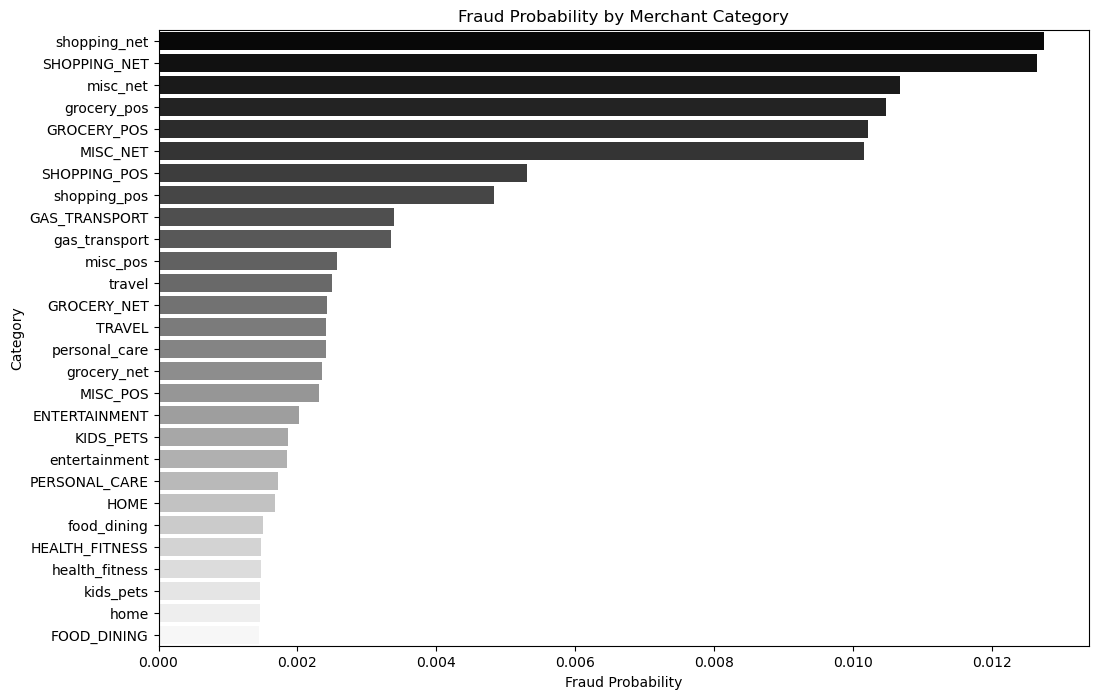

In [7]:
plt.figure(figsize=(12, 8))
category_fraud_prob = merged_data.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
sns.barplot(x=category_fraud_prob.values, y=category_fraud_prob.index, palette='grey')
plt.title('Fraud Probability by Merchant Category')
plt.xlabel('Fraud Probability')
plt.ylabel('Category')
plt.show()

The plot shows that fraudulent transactions tend to happen on shopping net, misc net, and grocery pos.

2. The frequency of fraudulent transactions depends on the transaction amounts.

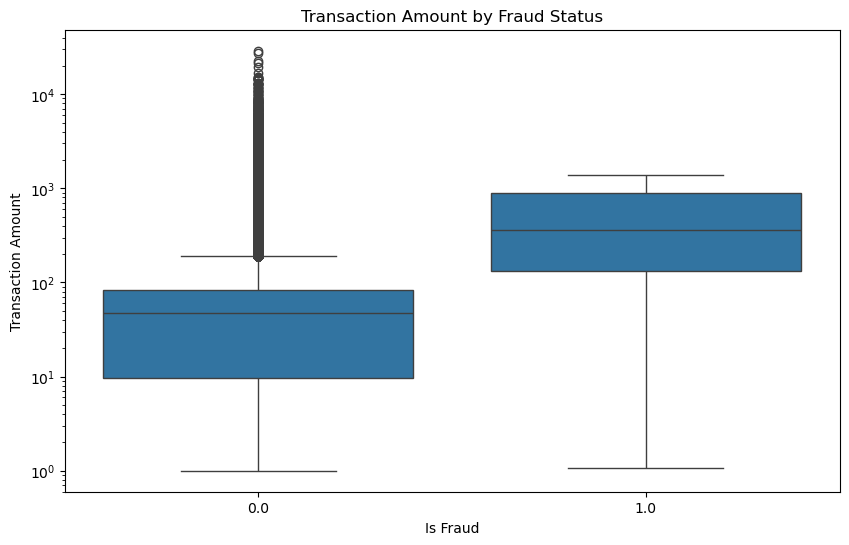

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=merged_data)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.yscale('log')  
plt.show()

The plot shows that fraudulent transactions tend to be between $100 to $1000 in range.